### CLIP


참조 자료
- https://www.youtube.com/watch?v=HkkaKI6NN-8
- 

이하 아래 코드에서 파 볼만한 것들  
- clip.load("ViT-B/32", device=device) <- done
- clip.tokenize <- done
- model.encode_image(image)
- model.encode_text(text)
- model(image, text)

![img.png](https://github.com/openai/CLIP/raw/main/CLIP.png)

#### 예시1
- 다이어그램 그림을 다이어그램으로 인식함

In [12]:
import torch
import clip
from PIL import Image
import numpy as np

import sys
sys.path.append("D:/00_PILSA/CLIP")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(clip.available_models())
model, preprocess = clip.load("ViT-B/32", device=device)

model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

# Vit-B/32 가장 작은 모델도 파라미터 수가 1.5억개 이다.
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

image = preprocess(Image.open("D:/00_PILSA/CLIP/CLIP.png")).unsqueeze(0).to(device) # torch.Size([1, 3, 224, 224])
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device) # torch.Size([3, 77])

print('\n')

with torch.no_grad():
    image_features = model.encode_image(image) # torch.Size([1, 512])
    text_features = model.encode_text(text) # torch.Size([3, 512])
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


Label probs: [[0.9927   0.004253 0.003016]]


### 예시2

- clip을 zero-shot prediction으로 활용하기 위해서는 아래 그림 처럼 가능한 클래스를 모두 token으로 만든다.
- 즉, "a photo of a beaver" ~ "a photo of a tractor" 까지 100개의 클래스를 모두 [1, 512] 사이즈로 임베딩 해야 하니 [100, 512] 가 된다.

Files already downloaded and verified

Top predictions:

        oak_tree: 40.16%
     willow_tree: 25.93%
      maple_tree: 15.97%
       pine_tree: 14.10%
       palm_tree: 1.19%


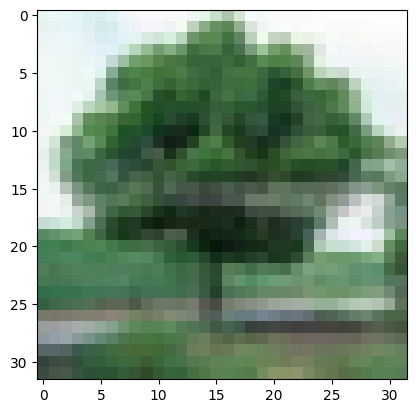

In [7]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[3635]
image_input = preprocess(image).unsqueeze(0).to(device)
# cifar 클래스의 "a photo of a {object}" 는 일단 다 생성한다!!
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True) # torch.Size([1, 512])
text_features /= text_features.norm(dim=-1, keepdim=True) # torch.Size([100, 512]) 
# 두개의 임베딩을 dot product 한다!!
simirality = (100.0 * image_features @ text_features.T).softmax(dim=-1) # torch.Size([1, 100])
values, indices = simirality[0].topk(5) # 텐서는 기본적으로 topk() 메소드가 내장되어 있나 보다

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

from matplotlib import pyplot as plt
plt.imshow(image, interpolation='nearest')

#### 이하 CLIP 모델

In [ ]:
def tokenize(texts: Union[str, List[str]], context_length: int=77, truncate: bool=False) -> Union[torch.IntTensor, torch.LongTensor]:
    """ 주어진 입력 스트링에 대해 토큰화된 표현으로 변경

        context_length : int
            문맥 길이, 모든 CLIP 모델은 77을 문맥 길이(?)로 사용한다.

        truncate: bool
            인코딩된 것이 문맥 길이 보다 길 경우 자른 건지 여부

        Returns
        -------
        shape = [입력 스트링 길이, 문맥 길이]의 2차원 텐서 반환
    """
    if isinstance(texts, str):
            texts = [texts]

        sot_token = _tokenizer.encoder["<|startoftext|>"]
        eot_token = _tokenizer.encoder["<|endoftext|>"]
        all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]

        # 2차원 빈 텐서 생성
        if packaging.version.parse(torch.__version__) < packaging.version.parse("1.8.0"):
            result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)
        else:
            result = torch.zeros(len(all_tokens), context_length, dtype=torch.int)

        for i, tokens in enumerate(all_tokens):
            if len(tokens) > context_length:
                if truncate:
                    tokens = tokens[:context_length]
                    tokens[-1] = eot_token
                else:
                    raise RuntimeError(f"Input {texts[i]} is too long for context length {context_length}")
            result[i, :len(tokens)] = torch.tensor(tokens)
        return result

In [ ]:
class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vison_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers = vision_layers,
                output_dim = embed_dim,
                heads = vision_heads,
                input_resolution = image_resolution,
                width = vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisionTransformer(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width,
                patch_size=vision_patch_size
            )
        
        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width) # nn.Embedding과 nn.Parameter 차이는??
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5 # c_proj?? -sqrt()??
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)
        
        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask